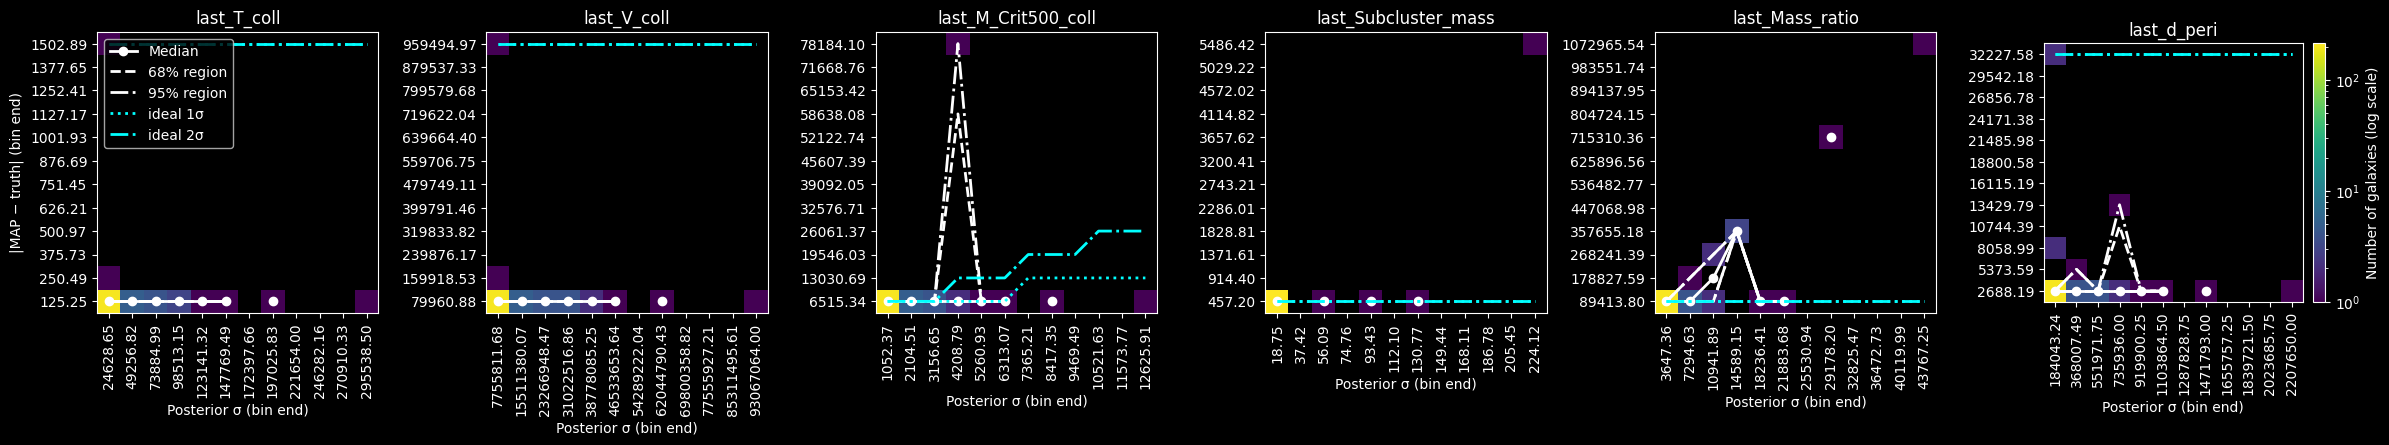

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]
def plot_std_vs_abs_map_error_with_percentiles(model_checkpoint: str,
                                               processed_dir: str = "processed_data",
                                               n_posterior_samples: int = 600,
                                               num_bins: int = 10,
                                               random_state: int = 42):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute absolute error = |MAP – truth|.
      • Build 2D histograms of (posterior std, abs error) with num_bins×num_bins.
      • In each std‐bin, compute:
          – median(abs error) (solid white line)
          – 16th/84th percentiles (dashed white lines for 68% region)
          – 2.5th/97.5th percentiles (dash-dot white lines for 95% region)
      • Overlay “ideal” lines assuming normal errors: abs error = 1·σ (dotted cyan) and =1.96·σ (dash-dot cyan).
      • Plot all targets in one row, shared log colorbar on the right.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    obs_sc = joblib.load(os.path.join(processed_dir, "obs_scaler.pkl"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full = dfX.values
    Y_full = dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X_full[idx_test]
    Y_test = Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)  # (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)

        std_phys[i] = samps.std(axis=0)
        # MAP via KDE
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) build histogram data and percentiles
    all_data = []
    stats    = []
    for d in range(D_tar):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        # bin edges
        std_bins = np.linspace(std_d.min(), std_d.max(), num_bins+1)
        err_bins = np.linspace(err_d.min(), err_d.max(), num_bins+1)

        # 2D histogram
        counts, _, _ = np.histogram2d(std_d, err_d, bins=[std_bins, err_bins])
        data = counts.T  # so x=std-bin, y=err-bin
        all_data.append(data)

        # percentiles per std‐bin
        med_i  = np.full(num_bins, np.nan)
        lo1_i  = np.full(num_bins, np.nan)
        hi1_i  = np.full(num_bins, np.nan)
        lo2_i  = np.full(num_bins, np.nan)
        hi2_i  = np.full(num_bins, np.nan)
        ideal1 = np.full(num_bins, np.nan)
        ideal2 = np.full(num_bins, np.nan)

        for b in range(num_bins):
            # select galaxies in std-bin b
            in_bin = (std_d >= std_bins[b]) & (std_d < std_bins[b+1])
            errs   = err_d[in_bin]
            if errs.size:
                med_i[b]  = np.clip(np.digitize(np.median(errs),  err_bins) - 1, 0, num_bins-1)
                lo1_i[b]  = np.clip(np.digitize(np.percentile(errs, 16), err_bins) - 1, 0, num_bins-1)
                hi1_i[b]  = np.clip(np.digitize(np.percentile(errs, 84), err_bins) - 1, 0, num_bins-1)
                lo2_i[b]  = np.clip(np.digitize(np.percentile(errs, 2.5),err_bins) - 1, 0, num_bins-1)
                hi2_i[b]  = np.clip(np.digitize(np.percentile(errs, 97.5),err_bins) - 1, 0, num_bins-1)
            # ideal lines: thresholds in physical units
            sigma = (std_bins[b] + std_bins[b+1]) / 2.0
            thresh1 = sigma * 1.0
            thresh2 = sigma * 1.96
            ideal1[b] = np.clip(np.digitize(thresh1, err_bins) - 1, 0, num_bins-1)
            ideal2[b] = np.clip(np.digitize(thresh2, err_bins) - 1, 0, num_bins-1)

        stats.append((med_i, lo1_i, hi1_i, lo2_i, hi2_i, ideal1, ideal2, std_bins, err_bins))

    # 6) shared log‐norm
    all_flat = np.concatenate([d.flatten() for d in all_data])
    pos = all_flat[all_flat>0]
    vmin = pos.min() if pos.size else 1
    vmax = all_flat.max()
    norm = LogNorm(vmin=max(1, vmin), vmax=vmax)

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar, 5), squeeze=False)
    ticks = np.arange(num_bins)
    for d, ax in enumerate(axes[0]):
        data, (med, lo1, hi1, lo2, hi2, id1, id2, std_bins, err_bins) = all_data[d], stats[d]
        x_ends = std_bins[1:]
        y_ends = err_bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest'
        )

        # percentiles
        ax.plot(ticks, med,   marker='o', linestyle='-',  linewidth=2, color='white', label='Median')
        ax.plot(ticks, lo1,  linestyle='--', linewidth=2, color='white', label='68% region' if d==0 else None)
        ax.plot(ticks, hi1,  linestyle='--', linewidth=2, color='white')
        ax.plot(ticks, lo2,  linestyle='-.', linewidth=2, color='white', label='95% region' if d==0 else None)
        ax.plot(ticks, hi2,  linestyle='-.', linewidth=2, color='white')

        # ideal lines
        ax.plot(ticks, id1, linestyle=':',  linewidth=2, color='cyan', label='ideal 1σ' if d==0 else None)
        ax.plot(ticks, id2, linestyle='-.', linewidth=2, color='cyan', label='ideal 2σ' if d==0 else None)

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Posterior σ (bin end)')
        if d == 0:
            ax.set_ylabel('|MAP − truth| (bin end)')
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{v:.2f}' for v in x_ends], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{v:.2f}' for v in y_ends])

    # single colorbar at end
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Number of galaxies (log scale)')

    # legend once
    axes[0][0].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_std_vs_abs_map_error_with_percentiles(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        random_state=42
    )


# 16.2

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'mean_V_coll',
    'last_V_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'mean_Mass_ratio'
]

def plot_std_vs_truth_2d_hist(model_checkpoint: str,
                              processed_dir: str = "processed_data",
                              n_posterior_samples: int = 600,
                              num_bins: int = 10,
                              random_state: int = 42):
    """
    For each target:
      • Sample the cINN posterior n_posterior_samples times.
      • Compute posterior σ (std) for each test galaxy.
      • Build a 2D histogram of (truth, σ) with num_bins×num_bins.
      • In each truth-bin, compute the median σ and the 10th/90th percentiles
        (so an 80% central region), and overlay:
          – solid white line: median σ vs. truth
          – dashed white lines: 10th & 90th‐percentile σ vs. truth
      • Plot all targets in one row, with a shared log-scaled colorbar at the right.
    """
    # 1) load data & scalers
    X = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    N, D_obs = X.shape
    _, D_tar = Y.shape
    assert D_tar == len(TARGET_COLS)

    # 2) split off test
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X[idx_test]
    Y_test = Y[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)  # shape (N_test, D_tar)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    model.load_state_dict(torch.load(model_checkpoint, map_location=device))
    model.eval()

    # 4) sample posterior: compute std_phys
    N_test = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            out = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = out[0] if isinstance(out, tuple) else out
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())  # (n_samples, D_tar)
        std_phys[i] = samps.std(axis=0)

    # 5) build 2D histogram data + percentile curves
    all_data = []
    curves   = []
    for d in range(D_tar):
        truth = truth_phys[:, d]
        sigma = std_phys[:, d]

        # define bin edges
        t_bins = np.linspace(truth.min(), truth.max(), num_bins+1)
        s_bins = np.linspace(sigma.min(), sigma.max(), num_bins+1)

        # build counts matrix
        counts = np.zeros((num_bins, num_bins), dtype=int)
        # group σ by truth-bin
        grouped = {b: [] for b in range(num_bins)}
        t_idx = np.digitize(truth, t_bins[1:-1], right=False)
        for i, b in enumerate(t_idx):
            if 0 <= b < num_bins:
                grouped[b].append(sigma[i])

        # fill histogram row-by-row
        for b in range(num_bins):
            arr = np.array(grouped[b])
            if arr.size:
                c, _ = np.histogram(arr, bins=s_bins)
                counts[b] = c

        # compute percentiles
        med_idx = np.full(num_bins, np.nan)
        lo_idx  = np.full(num_bins, np.nan)
        hi_idx  = np.full(num_bins, np.nan)
        for b in range(num_bins):
            arr = np.array(grouped[b])
            if arr.size:
                med = np.median(arr)
                lo, hi = np.percentile(arr, [10, 90])
                # map σ values to σ-bin indices
                med_idx[b] = np.clip(np.digitize(med, s_bins) - 1, 0, num_bins-1)
                lo_idx[b]  = np.clip(np.digitize(lo,  s_bins) - 1, 0, num_bins-1)
                hi_idx[b]  = np.clip(np.digitize(hi,  s_bins) - 1, 0, num_bins-1)

        all_data.append(counts.T)  # transpose for x=truth, y=σ
        curves.append((med_idx, lo_idx, hi_idx, t_bins, s_bins))

    # 6) shared log‐norm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    vmin = pos.min() if pos.size else 1
    vmax = flat.max()
    norm = LogNorm(vmin=max(1, vmin), vmax=vmax)

    # 7) plot subplots
    fig, axes = plt.subplots(1, D_tar, figsize=(4*D_tar, 5), squeeze=False)
    x = np.arange(num_bins)
    for d, ax in enumerate(axes[0]):
        data, (med_idx, lo_idx, hi_idx, t_bins, s_bins) = all_data[d], curves[d]
        t_ends = t_bins[1:]
        s_ends = s_bins[1:]

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest'
        )

        # overlay median & 10/90 percentile lines
        ax.plot(x, med_idx, marker='o', linestyle='-', linewidth=2, color='white', label='Median')
        ax.plot(x, lo_idx, linestyle='--', linewidth=2, color='white', label='10th/90th pct' if d==0 else None)
        ax.plot(x, hi_idx, linestyle='--', linewidth=2, color='white')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('Truth bin end')
        if d == 0:
            ax.set_ylabel('Posterior σ bin end')

        ax.set_xticks(x)
        ax.set_xticklabels([f'{v:.2f}' for v in t_ends], rotation=90)
        ax.set_yticks(x)
        ax.set_yticklabels([f'{v:.2f}' for v in s_ends])

    # single colorbar at right
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Number of galaxies (log scale)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_std_vs_truth_2d_hist(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=40,
        random_state=42
    )


RuntimeError: Error(s) in loading state_dict for cINN:
	Missing key(s) in state_dict: "flow.module_list.0.subnet1.0.weight", "flow.module_list.0.subnet1.0.bias", "flow.module_list.0.subnet1.3.weight", "flow.module_list.0.subnet1.3.bias", "flow.module_list.0.subnet2.0.weight", "flow.module_list.0.subnet2.0.bias", "flow.module_list.0.subnet2.3.weight", "flow.module_list.0.subnet2.3.bias", "flow.module_list.1.perm", "flow.module_list.1.perm_inv", "flow.module_list.2.subnet1.0.weight", "flow.module_list.2.subnet1.0.bias", "flow.module_list.2.subnet1.3.weight", "flow.module_list.2.subnet1.3.bias", "flow.module_list.2.subnet2.0.weight", "flow.module_list.2.subnet2.0.bias", "flow.module_list.2.subnet2.3.weight", "flow.module_list.2.subnet2.3.bias", "flow.module_list.3.perm", "flow.module_list.3.perm_inv", "flow.module_list.4.subnet1.0.weight", "flow.module_list.4.subnet1.0.bias", "flow.module_list.4.subnet1.3.weight", "flow.module_list.4.subnet1.3.bias", "flow.module_list.4.subnet2.0.weight", "flow.module_list.4.subnet2.0.bias", "flow.module_list.4.subnet2.3.weight", "flow.module_list.4.subnet2.3.bias", "flow.module_list.5.perm", "flow.module_list.5.perm_inv", "flow.module_list.6.subnet1.0.weight", "flow.module_list.6.subnet1.0.bias", "flow.module_list.6.subnet1.3.weight", "flow.module_list.6.subnet1.3.bias", "flow.module_list.6.subnet2.0.weight", "flow.module_list.6.subnet2.0.bias", "flow.module_list.6.subnet2.3.weight", "flow.module_list.6.subnet2.3.bias", "flow.module_list.7.perm", "flow.module_list.7.perm_inv", "flow.module_list.8.subnet1.0.weight", "flow.module_list.8.subnet1.0.bias", "flow.module_list.8.subnet1.3.weight", "flow.module_list.8.subnet1.3.bias", "flow.module_list.8.subnet2.0.weight", "flow.module_list.8.subnet2.0.bias", "flow.module_list.8.subnet2.3.weight", "flow.module_list.8.subnet2.3.bias", "flow.module_list.9.perm", "flow.module_list.9.perm_inv", "flow.module_list.10.subnet1.0.weight", "flow.module_list.10.subnet1.0.bias", "flow.module_list.10.subnet1.3.weight", "flow.module_list.10.subnet1.3.bias", "flow.module_list.10.subnet2.0.weight", "flow.module_list.10.subnet2.0.bias", "flow.module_list.10.subnet2.3.weight", "flow.module_list.10.subnet2.3.bias", "flow.module_list.11.perm", "flow.module_list.11.perm_inv", "flow.module_list.12.subnet1.0.weight", "flow.module_list.12.subnet1.0.bias", "flow.module_list.12.subnet1.3.weight", "flow.module_list.12.subnet1.3.bias", "flow.module_list.12.subnet2.0.weight", "flow.module_list.12.subnet2.0.bias", "flow.module_list.12.subnet2.3.weight", "flow.module_list.12.subnet2.3.bias", "flow.module_list.13.perm", "flow.module_list.13.perm_inv", "flow.module_list.14.subnet1.0.weight", "flow.module_list.14.subnet1.0.bias", "flow.module_list.14.subnet1.3.weight", "flow.module_list.14.subnet1.3.bias", "flow.module_list.14.subnet2.0.weight", "flow.module_list.14.subnet2.0.bias", "flow.module_list.14.subnet2.3.weight", "flow.module_list.14.subnet2.3.bias", "flow.module_list.15.perm", "flow.module_list.15.perm_inv", "flow.module_list.16.subnet1.0.weight", "flow.module_list.16.subnet1.0.bias", "flow.module_list.16.subnet1.3.weight", "flow.module_list.16.subnet1.3.bias", "flow.module_list.16.subnet2.0.weight", "flow.module_list.16.subnet2.0.bias", "flow.module_list.16.subnet2.3.weight", "flow.module_list.16.subnet2.3.bias", "flow.module_list.17.perm", "flow.module_list.17.perm_inv", "flow.module_list.18.subnet1.0.weight", "flow.module_list.18.subnet1.0.bias", "flow.module_list.18.subnet1.3.weight", "flow.module_list.18.subnet1.3.bias", "flow.module_list.18.subnet2.0.weight", "flow.module_list.18.subnet2.0.bias", "flow.module_list.18.subnet2.3.weight", "flow.module_list.18.subnet2.3.bias", "flow.module_list.19.perm", "flow.module_list.19.perm_inv", "flow.module_list.20.subnet1.0.weight", "flow.module_list.20.subnet1.0.bias", "flow.module_list.20.subnet1.3.weight", "flow.module_list.20.subnet1.3.bias", "flow.module_list.20.subnet2.0.weight", "flow.module_list.20.subnet2.0.bias", "flow.module_list.20.subnet2.3.weight", "flow.module_list.20.subnet2.3.bias", "flow.module_list.21.perm", "flow.module_list.21.perm_inv", "flow.module_list.22.subnet1.0.weight", "flow.module_list.22.subnet1.0.bias", "flow.module_list.22.subnet1.3.weight", "flow.module_list.22.subnet1.3.bias", "flow.module_list.22.subnet2.0.weight", "flow.module_list.22.subnet2.0.bias", "flow.module_list.22.subnet2.3.weight", "flow.module_list.22.subnet2.3.bias", "flow.module_list.23.perm", "flow.module_list.23.perm_inv". 
	Unexpected key(s) in state_dict: "flow.module_list.24.perm", "flow.module_list.24.perm_inv", "flow.module_list.25.subnet_s1.0.weight", "flow.module_list.25.subnet_s1.0.bias", "flow.module_list.25.subnet_s1.2.weight", "flow.module_list.25.subnet_s1.2.bias", "flow.module_list.25.subnet_t1.0.weight", "flow.module_list.25.subnet_t1.0.bias", "flow.module_list.25.subnet_t1.2.weight", "flow.module_list.25.subnet_t1.2.bias", "flow.module_list.25.subnet_s2.0.weight", "flow.module_list.25.subnet_s2.0.bias", "flow.module_list.25.subnet_s2.2.weight", "flow.module_list.25.subnet_s2.2.bias", "flow.module_list.25.subnet_t2.0.weight", "flow.module_list.25.subnet_t2.0.bias", "flow.module_list.25.subnet_t2.2.weight", "flow.module_list.25.subnet_t2.2.bias", "flow.module_list.26.perm", "flow.module_list.26.perm_inv", "flow.module_list.27.subnet_s1.0.weight", "flow.module_list.27.subnet_s1.0.bias", "flow.module_list.27.subnet_s1.2.weight", "flow.module_list.27.subnet_s1.2.bias", "flow.module_list.27.subnet_t1.0.weight", "flow.module_list.27.subnet_t1.0.bias", "flow.module_list.27.subnet_t1.2.weight", "flow.module_list.27.subnet_t1.2.bias", "flow.module_list.27.subnet_s2.0.weight", "flow.module_list.27.subnet_s2.0.bias", "flow.module_list.27.subnet_s2.2.weight", "flow.module_list.27.subnet_s2.2.bias", "flow.module_list.27.subnet_t2.0.weight", "flow.module_list.27.subnet_t2.0.bias", "flow.module_list.27.subnet_t2.2.weight", "flow.module_list.27.subnet_t2.2.bias", "flow.module_list.28.perm", "flow.module_list.28.perm_inv", "flow.module_list.29.subnet_s1.0.weight", "flow.module_list.29.subnet_s1.0.bias", "flow.module_list.29.subnet_s1.2.weight", "flow.module_list.29.subnet_s1.2.bias", "flow.module_list.29.subnet_t1.0.weight", "flow.module_list.29.subnet_t1.0.bias", "flow.module_list.29.subnet_t1.2.weight", "flow.module_list.29.subnet_t1.2.bias", "flow.module_list.29.subnet_s2.0.weight", "flow.module_list.29.subnet_s2.0.bias", "flow.module_list.29.subnet_s2.2.weight", "flow.module_list.29.subnet_s2.2.bias", "flow.module_list.29.subnet_t2.0.weight", "flow.module_list.29.subnet_t2.0.bias", "flow.module_list.29.subnet_t2.2.weight", "flow.module_list.29.subnet_t2.2.bias", "flow.module_list.30.perm", "flow.module_list.30.perm_inv", "flow.module_list.31.subnet_s1.0.weight", "flow.module_list.31.subnet_s1.0.bias", "flow.module_list.31.subnet_s1.2.weight", "flow.module_list.31.subnet_s1.2.bias", "flow.module_list.31.subnet_t1.0.weight", "flow.module_list.31.subnet_t1.0.bias", "flow.module_list.31.subnet_t1.2.weight", "flow.module_list.31.subnet_t1.2.bias", "flow.module_list.31.subnet_s2.0.weight", "flow.module_list.31.subnet_s2.0.bias", "flow.module_list.31.subnet_s2.2.weight", "flow.module_list.31.subnet_s2.2.bias", "flow.module_list.31.subnet_t2.0.weight", "flow.module_list.31.subnet_t2.0.bias", "flow.module_list.31.subnet_t2.2.weight", "flow.module_list.31.subnet_t2.2.bias", "flow.module_list.32.perm", "flow.module_list.32.perm_inv", "flow.module_list.33.global_scale", "flow.module_list.33.global_offset", "flow.module_list.33.w_perm", "flow.module_list.33.w_perm_inv", "flow.module_list.33.subnet.0.weight", "flow.module_list.33.subnet.0.bias", "flow.module_list.33.subnet.2.weight", "flow.module_list.33.subnet.2.bias", "flow.module_list.0.global_scale", "flow.module_list.0.global_offset", "flow.module_list.0.w_perm", "flow.module_list.0.w_perm_inv", "flow.module_list.0.subnet.0.weight", "flow.module_list.0.subnet.0.bias", "flow.module_list.0.subnet.2.weight", "flow.module_list.0.subnet.2.bias", "flow.module_list.0.subnet.4.weight", "flow.module_list.0.subnet.4.bias", "flow.module_list.1.subnet_s1.0.weight", "flow.module_list.1.subnet_s1.0.bias", "flow.module_list.1.subnet_s1.2.weight", "flow.module_list.1.subnet_s1.2.bias", "flow.module_list.1.subnet_t1.0.weight", "flow.module_list.1.subnet_t1.0.bias", "flow.module_list.1.subnet_t1.2.weight", "flow.module_list.1.subnet_t1.2.bias", "flow.module_list.1.subnet_s2.0.weight", "flow.module_list.1.subnet_s2.0.bias", "flow.module_list.1.subnet_s2.2.weight", "flow.module_list.1.subnet_s2.2.bias", "flow.module_list.1.subnet_t2.0.weight", "flow.module_list.1.subnet_t2.0.bias", "flow.module_list.1.subnet_t2.2.weight", "flow.module_list.1.subnet_t2.2.bias", "flow.module_list.2.perm", "flow.module_list.2.perm_inv", "flow.module_list.3.subnet_s1.0.weight", "flow.module_list.3.subnet_s1.0.bias", "flow.module_list.3.subnet_s1.2.weight", "flow.module_list.3.subnet_s1.2.bias", "flow.module_list.3.subnet_t1.0.weight", "flow.module_list.3.subnet_t1.0.bias", "flow.module_list.3.subnet_t1.2.weight", "flow.module_list.3.subnet_t1.2.bias", "flow.module_list.3.subnet_s2.0.weight", "flow.module_list.3.subnet_s2.0.bias", "flow.module_list.3.subnet_s2.2.weight", "flow.module_list.3.subnet_s2.2.bias", "flow.module_list.3.subnet_t2.0.weight", "flow.module_list.3.subnet_t2.0.bias", "flow.module_list.3.subnet_t2.2.weight", "flow.module_list.3.subnet_t2.2.bias", "flow.module_list.4.perm", "flow.module_list.4.perm_inv", "flow.module_list.5.subnet_s1.0.weight", "flow.module_list.5.subnet_s1.0.bias", "flow.module_list.5.subnet_s1.2.weight", "flow.module_list.5.subnet_s1.2.bias", "flow.module_list.5.subnet_t1.0.weight", "flow.module_list.5.subnet_t1.0.bias", "flow.module_list.5.subnet_t1.2.weight", "flow.module_list.5.subnet_t1.2.bias", "flow.module_list.5.subnet_s2.0.weight", "flow.module_list.5.subnet_s2.0.bias", "flow.module_list.5.subnet_s2.2.weight", "flow.module_list.5.subnet_s2.2.bias", "flow.module_list.5.subnet_t2.0.weight", "flow.module_list.5.subnet_t2.0.bias", "flow.module_list.5.subnet_t2.2.weight", "flow.module_list.5.subnet_t2.2.bias", "flow.module_list.6.perm", "flow.module_list.6.perm_inv", "flow.module_list.7.subnet_s1.0.weight", "flow.module_list.7.subnet_s1.0.bias", "flow.module_list.7.subnet_s1.2.weight", "flow.module_list.7.subnet_s1.2.bias", "flow.module_list.7.subnet_t1.0.weight", "flow.module_list.7.subnet_t1.0.bias", "flow.module_list.7.subnet_t1.2.weight", "flow.module_list.7.subnet_t1.2.bias", "flow.module_list.7.subnet_s2.0.weight", "flow.module_list.7.subnet_s2.0.bias", "flow.module_list.7.subnet_s2.2.weight", "flow.module_list.7.subnet_s2.2.bias", "flow.module_list.7.subnet_t2.0.weight", "flow.module_list.7.subnet_t2.0.bias", "flow.module_list.7.subnet_t2.2.weight", "flow.module_list.7.subnet_t2.2.bias", "flow.module_list.8.perm", "flow.module_list.8.perm_inv", "flow.module_list.9.subnet_s1.0.weight", "flow.module_list.9.subnet_s1.0.bias", "flow.module_list.9.subnet_s1.2.weight", "flow.module_list.9.subnet_s1.2.bias", "flow.module_list.9.subnet_t1.0.weight", "flow.module_list.9.subnet_t1.0.bias", "flow.module_list.9.subnet_t1.2.weight", "flow.module_list.9.subnet_t1.2.bias", "flow.module_list.9.subnet_s2.0.weight", "flow.module_list.9.subnet_s2.0.bias", "flow.module_list.9.subnet_s2.2.weight", "flow.module_list.9.subnet_s2.2.bias", "flow.module_list.9.subnet_t2.0.weight", "flow.module_list.9.subnet_t2.0.bias", "flow.module_list.9.subnet_t2.2.weight", "flow.module_list.9.subnet_t2.2.bias", "flow.module_list.10.perm", "flow.module_list.10.perm_inv", "flow.module_list.11.subnet_s1.0.weight", "flow.module_list.11.subnet_s1.0.bias", "flow.module_list.11.subnet_s1.2.weight", "flow.module_list.11.subnet_s1.2.bias", "flow.module_list.11.subnet_t1.0.weight", "flow.module_list.11.subnet_t1.0.bias", "flow.module_list.11.subnet_t1.2.weight", "flow.module_list.11.subnet_t1.2.bias", "flow.module_list.11.subnet_s2.0.weight", "flow.module_list.11.subnet_s2.0.bias", "flow.module_list.11.subnet_s2.2.weight", "flow.module_list.11.subnet_s2.2.bias", "flow.module_list.11.subnet_t2.0.weight", "flow.module_list.11.subnet_t2.0.bias", "flow.module_list.11.subnet_t2.2.weight", "flow.module_list.11.subnet_t2.2.bias", "flow.module_list.12.perm", "flow.module_list.12.perm_inv", "flow.module_list.13.subnet_s1.0.weight", "flow.module_list.13.subnet_s1.0.bias", "flow.module_list.13.subnet_s1.2.weight", "flow.module_list.13.subnet_s1.2.bias", "flow.module_list.13.subnet_t1.0.weight", "flow.module_list.13.subnet_t1.0.bias", "flow.module_list.13.subnet_t1.2.weight", "flow.module_list.13.subnet_t1.2.bias", "flow.module_list.13.subnet_s2.0.weight", "flow.module_list.13.subnet_s2.0.bias", "flow.module_list.13.subnet_s2.2.weight", "flow.module_list.13.subnet_s2.2.bias", "flow.module_list.13.subnet_t2.0.weight", "flow.module_list.13.subnet_t2.0.bias", "flow.module_list.13.subnet_t2.2.weight", "flow.module_list.13.subnet_t2.2.bias", "flow.module_list.14.perm", "flow.module_list.14.perm_inv", "flow.module_list.15.subnet_s1.0.weight", "flow.module_list.15.subnet_s1.0.bias", "flow.module_list.15.subnet_s1.2.weight", "flow.module_list.15.subnet_s1.2.bias", "flow.module_list.15.subnet_t1.0.weight", "flow.module_list.15.subnet_t1.0.bias", "flow.module_list.15.subnet_t1.2.weight", "flow.module_list.15.subnet_t1.2.bias", "flow.module_list.15.subnet_s2.0.weight", "flow.module_list.15.subnet_s2.0.bias", "flow.module_list.15.subnet_s2.2.weight", "flow.module_list.15.subnet_s2.2.bias", "flow.module_list.15.subnet_t2.0.weight", "flow.module_list.15.subnet_t2.0.bias", "flow.module_list.15.subnet_t2.2.weight", "flow.module_list.15.subnet_t2.2.bias", "flow.module_list.16.perm", "flow.module_list.16.perm_inv", "flow.module_list.17.subnet_s1.0.weight", "flow.module_list.17.subnet_s1.0.bias", "flow.module_list.17.subnet_s1.2.weight", "flow.module_list.17.subnet_s1.2.bias", "flow.module_list.17.subnet_t1.0.weight", "flow.module_list.17.subnet_t1.0.bias", "flow.module_list.17.subnet_t1.2.weight", "flow.module_list.17.subnet_t1.2.bias", "flow.module_list.17.subnet_s2.0.weight", "flow.module_list.17.subnet_s2.0.bias", "flow.module_list.17.subnet_s2.2.weight", "flow.module_list.17.subnet_s2.2.bias", "flow.module_list.17.subnet_t2.0.weight", "flow.module_list.17.subnet_t2.0.bias", "flow.module_list.17.subnet_t2.2.weight", "flow.module_list.17.subnet_t2.2.bias", "flow.module_list.18.perm", "flow.module_list.18.perm_inv", "flow.module_list.19.subnet_s1.0.weight", "flow.module_list.19.subnet_s1.0.bias", "flow.module_list.19.subnet_s1.2.weight", "flow.module_list.19.subnet_s1.2.bias", "flow.module_list.19.subnet_t1.0.weight", "flow.module_list.19.subnet_t1.0.bias", "flow.module_list.19.subnet_t1.2.weight", "flow.module_list.19.subnet_t1.2.bias", "flow.module_list.19.subnet_s2.0.weight", "flow.module_list.19.subnet_s2.0.bias", "flow.module_list.19.subnet_s2.2.weight", "flow.module_list.19.subnet_s2.2.bias", "flow.module_list.19.subnet_t2.0.weight", "flow.module_list.19.subnet_t2.0.bias", "flow.module_list.19.subnet_t2.2.weight", "flow.module_list.19.subnet_t2.2.bias", "flow.module_list.20.perm", "flow.module_list.20.perm_inv", "flow.module_list.21.subnet_s1.0.weight", "flow.module_list.21.subnet_s1.0.bias", "flow.module_list.21.subnet_s1.2.weight", "flow.module_list.21.subnet_s1.2.bias", "flow.module_list.21.subnet_t1.0.weight", "flow.module_list.21.subnet_t1.0.bias", "flow.module_list.21.subnet_t1.2.weight", "flow.module_list.21.subnet_t1.2.bias", "flow.module_list.21.subnet_s2.0.weight", "flow.module_list.21.subnet_s2.0.bias", "flow.module_list.21.subnet_s2.2.weight", "flow.module_list.21.subnet_s2.2.bias", "flow.module_list.21.subnet_t2.0.weight", "flow.module_list.21.subnet_t2.0.bias", "flow.module_list.21.subnet_t2.2.weight", "flow.module_list.21.subnet_t2.2.bias", "flow.module_list.22.perm", "flow.module_list.22.perm_inv", "flow.module_list.23.subnet_s1.0.weight", "flow.module_list.23.subnet_s1.0.bias", "flow.module_list.23.subnet_s1.2.weight", "flow.module_list.23.subnet_s1.2.bias", "flow.module_list.23.subnet_t1.0.weight", "flow.module_list.23.subnet_t1.0.bias", "flow.module_list.23.subnet_t1.2.weight", "flow.module_list.23.subnet_t1.2.bias", "flow.module_list.23.subnet_s2.0.weight", "flow.module_list.23.subnet_s2.0.bias", "flow.module_list.23.subnet_s2.2.weight", "flow.module_list.23.subnet_s2.2.bias", "flow.module_list.23.subnet_t2.0.weight", "flow.module_list.23.subnet_t2.0.bias", "flow.module_list.23.subnet_t2.2.weight", "flow.module_list.23.subnet_t2.2.bias". 

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

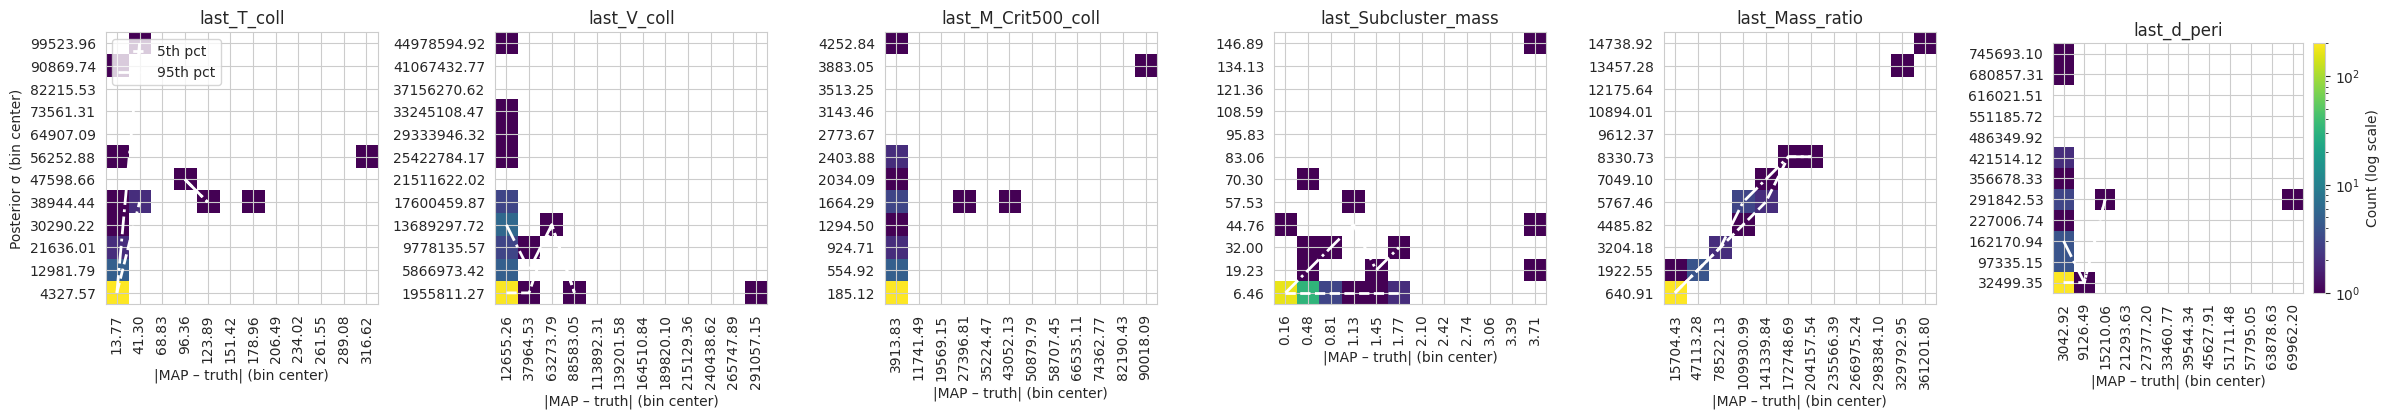

In [4]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_5_95(model_checkpoint: str,
                           processed_dir: str = "processed_data",
                           n_posterior_samples: int = 600,
                           num_bins: int = 10,
                           random_state: int = 42):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute absolute error = |MAP – truth|.
      • Bin by error into num_bins.
      • In each error‐bin, keep only std values between that bin’s 5th–95th percentile
        (or all if only one), then histogram into std‐bins.
      • Overlay:
          – dashed white line at the 5th percentile of std
          – dash-dot white line at the 95th percentile of std
      • Plot all targets in one row, shared log colorbar on the right.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load data & scalers
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) split test set
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) build histogram data and 5th/95th‐percentile indices per error‐bin
    all_data = []
    stats    = []

    for d in range(D_tar):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        # error‐axis bins
        err_bins = np.linspace(err_d.min(), err_d.max(), num_bins + 1)
        std_bins = np.linspace(std_d.min(), std_d.max(), num_bins + 1)

        # 2D histogram x=err, y=std
        counts, _, _ = np.histogram2d(err_d, std_d, bins=[err_bins, std_bins])
        all_data.append(counts.T)

        # percentiles per error‐bin
        p5_idx  = np.full(num_bins, np.nan)
        p95_idx = np.full(num_bins, np.nan)
        for b in range(num_bins):
            mask = (err_d >= err_bins[b]) & (err_d < err_bins[b+1])
            stds = std_d[mask]
            if stds.size:
                p5  = np.percentile(stds, 5)
                p95 = np.percentile(stds, 95)
                p5_idx[b]  = np.clip(np.digitize(p5,  std_bins) - 1, 0, num_bins - 1)
                p95_idx[b] = np.clip(np.digitize(p95, std_bins) - 1, 0, num_bins - 1)

        stats.append((p5_idx, p95_idx, err_bins, std_bins))

    # 6) shared log‐norm for color
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    ticks = np.arange(num_bins)

    for d, ax in enumerate(axes[0]):
        data, (p5_idx, p95_idx, err_bins, std_bins) = all_data[d], stats[d]
        x_centers = 0.5 * (err_bins[:-1] + err_bins[1:])
        y_centers = 0.5 * (std_bins[:-1] + std_bins[1:])

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )
        # 5th percentile (dashed white)
        ax.plot(ticks, p5_idx, '--', linewidth=2, color='white', label='5th pct')
        # 95th percentile (dash-dot white)
        ax.plot(ticks, p95_idx, '-.', linewidth=2, color='white', label='95th pct')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('|MAP – truth| (bin center)')
        if d == 0:
            ax.set_ylabel('Posterior σ (bin center)')

        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{v:.2f}' for v in x_centers], rotation=90)
        ax.set_yticks(ticks)
        ax.set_yticklabels([f'{v:.2f}' for v in y_centers])

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Count (log scale)')

    axes[0][0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_5_95(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        random_state=42
    )


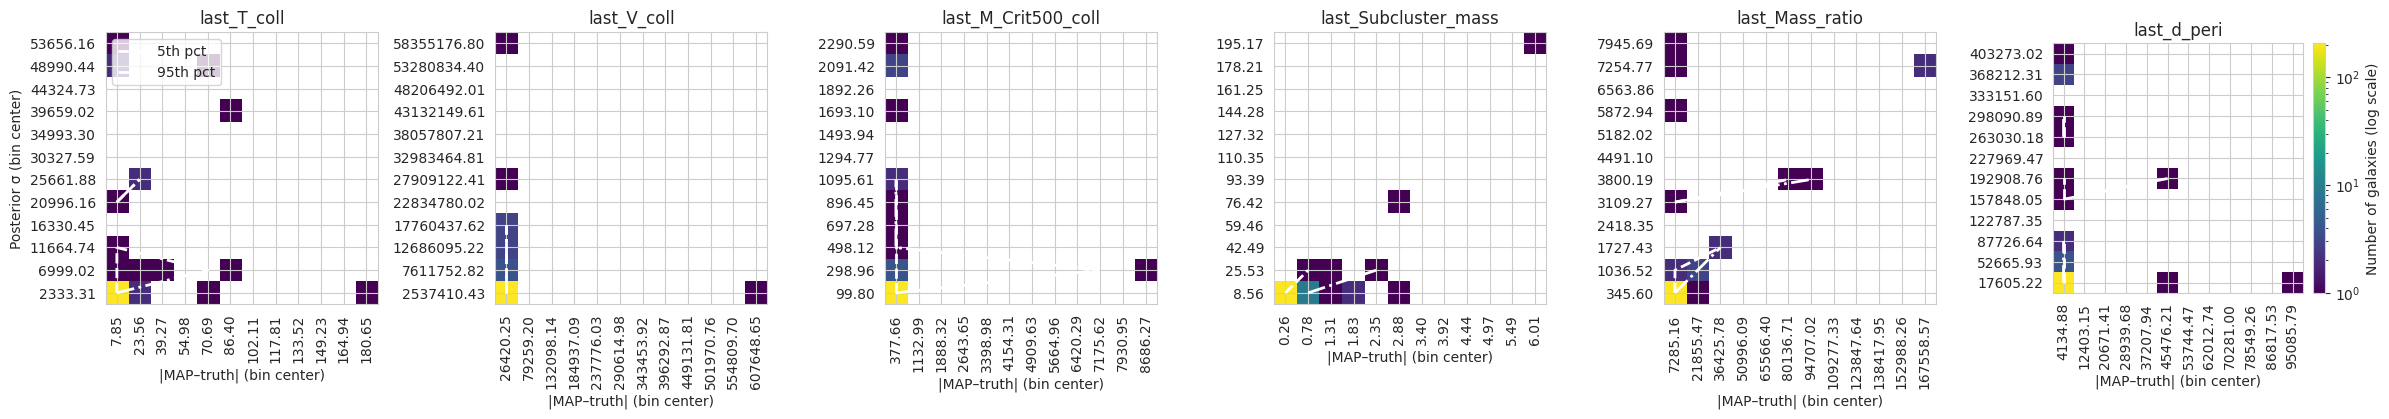

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_5_95(model_checkpoint: str,
                           processed_dir: str = "processed_data",
                           n_posterior_samples: int = 600,
                           num_bins: int = 10,
                           random_state: int = 42):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Bin by std into num_bins.
      • In each std‐bin, compute the 5th & 95th percentiles of abs error.
      • Build 2D histogram of (err, std) with num_bins×num_bins.
      • Overlay:
          – dashed white line at 5th percentile of error (x vs std)
          – dash-dot white line at 95th percentile of error
      • Plot all targets in one row with viridis log‐scaled colorbar.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) build histogram data and percentiles per std‐bin
    all_data = []
    stats    = []

    for d in range(D_tar):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        # define bins
        std_bins = np.linspace(std_d.min(), std_d.max(), num_bins + 1)
        err_bins = np.linspace(err_d.min(), err_d.max(), num_bins + 1)

        # 2D histogram x=err, y=std
        counts, _, _ = np.histogram2d(err_d, std_d, bins=[err_bins, std_bins])
        all_data.append(counts.T)

        # compute 5th & 95th percentiles of error in each std‐bin
        p5_idx  = np.full(num_bins, np.nan)
        p95_idx = np.full(num_bins, np.nan)
        for b in range(num_bins):
            mask = (std_d >= std_bins[b]) & (std_d < std_bins[b+1])
            errs = err_d[mask]
            if errs.size:
                p5  = np.percentile(errs, 5)
                p95 = np.percentile(errs, 95)
                p5_idx[b]  = np.clip(np.digitize(p5,  err_bins) - 1, 0, num_bins-1)
                p95_idx[b] = np.clip(np.digitize(p95, err_bins) - 1, 0, num_bins-1)

        stats.append((p5_idx, p95_idx, err_bins, std_bins))

    # 6) shared LogNorm
    flat = np.concatenate([d.flatten() for d in all_data])
    pos  = flat[flat > 0]
    norm = LogNorm(vmin=max(1, pos.min() if pos.size else 1), vmax=flat.max())

    # 7) plot
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    bins_idx = np.arange(num_bins)

    for d, ax in enumerate(axes[0]):
        data, (p5_idx, p95_idx, err_bins, std_bins) = all_data[d], stats[d]
        x_centers = 0.5 * (err_bins[:-1] + err_bins[1:])
        y_centers = 0.5 * (std_bins[:-1] + std_bins[1:])

        im = ax.imshow(
            data,
            origin='lower',
            norm=norm,
            aspect='equal',
            interpolation='nearest',
            cmap='viridis'
        )

        # dashed white 5th percentile
        ax.plot(p5_idx, bins_idx, '--', linewidth=2, color='white', label='5th pct')
        # dash-dot white 95th percentile
        ax.plot(p95_idx, bins_idx, '-.', linewidth=2, color='white', label='95th pct')

        ax.set_title(TARGET_COLS[d])
        ax.set_xlabel('|MAP–truth| (bin center)')
        if d == 0:
            ax.set_ylabel('Posterior σ (bin center)')

        ax.set_xticks(bins_idx)
        ax.set_xticklabels([f'{v:.2f}' for v in x_centers], rotation=90)
        ax.set_yticks(bins_idx)
        ax.set_yticklabels([f'{v:.2f}' for v in y_centers])

    # single colorbar
    divider = make_axes_locatable(axes[0][-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Number of galaxies (log scale)')

    axes[0][0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_5_95(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        random_state=42
    )


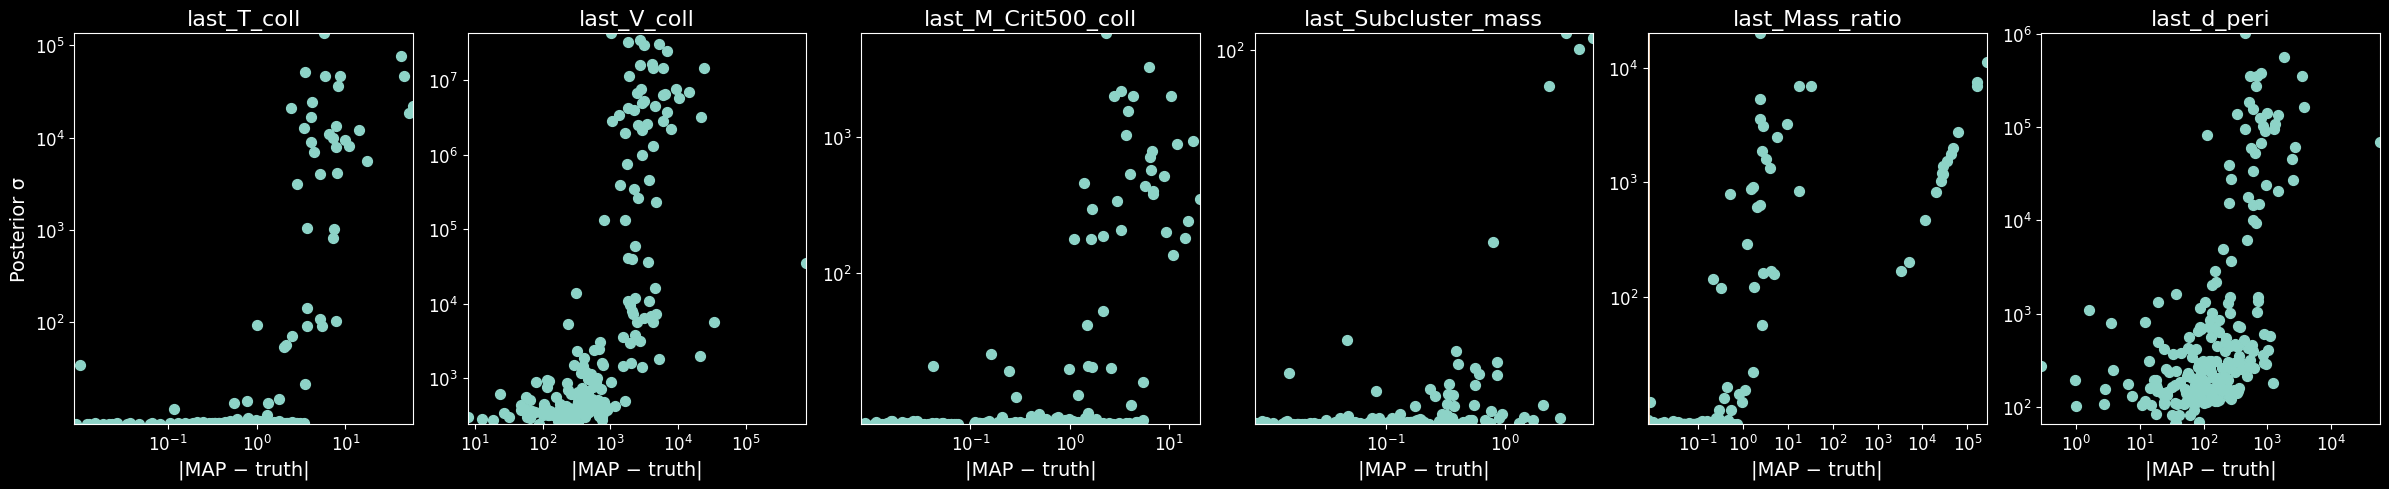

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])
        
        # scatter
        ax.scatter(err_d, std_d, s=50, alpha=1.0)

        # symlog on both axes
        ax.set_xscale("symlog", linthresh=linthresh_x, linscale=1.0)
        ax.set_yscale("symlog", linthresh=linthresh_y, linscale=1.0)

        # vertical zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # lock axis limits to data ranges
        ax.set_xlim(err_d.min(), err_d.max())
        ax.set_ylim(std_d.min(), std_d.max())

        # labels & title
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        linthresh_x=0.1,
        linthresh_y=100,
        random_state=42
    )


# since nothing seems to be working adn for some reason the sigma is very high in some data, so we only plot this fir the 5,95th pecentile of the data

In [7]:
import seaborn as sns
sns.set_style("white")

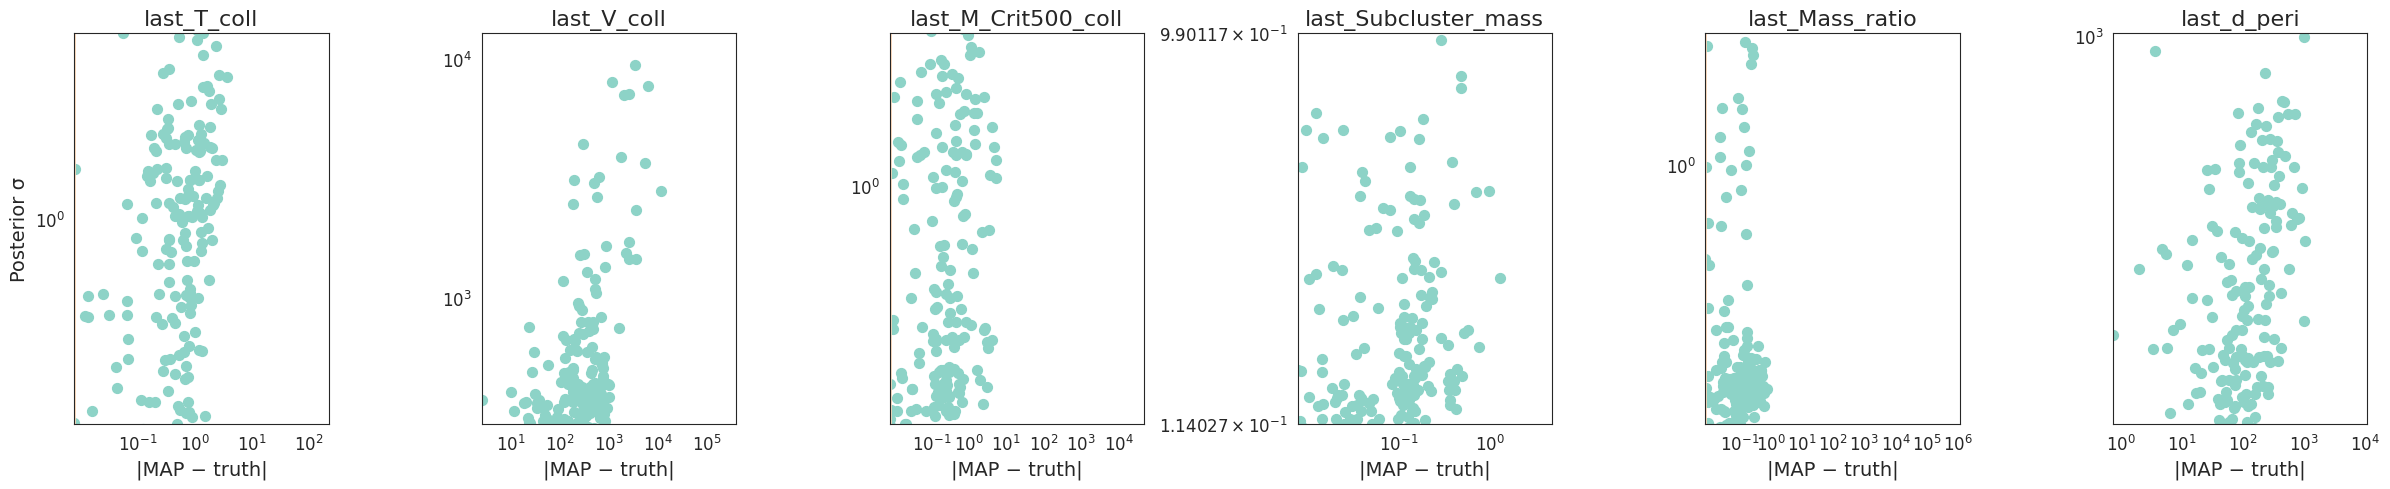

In [10]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])
        
        p5, p95 = np.percentile(std_d, [5, 80])
        # scatter
        ax.scatter(err_d, std_d, s=50, alpha=1.0)

        # symlog on both axes
        ax.set_xscale("symlog", linthresh=linthresh_x, linscale=1.0)
        ax.set_yscale("symlog", linthresh=linthresh_y, linscale=1.0)

        # vertical zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # lock axis limits to data ranges
        ax.set_xlim(err_d.min(), err_d.max())
        ax.set_ylim(p5, p95)

        # labels & title
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )


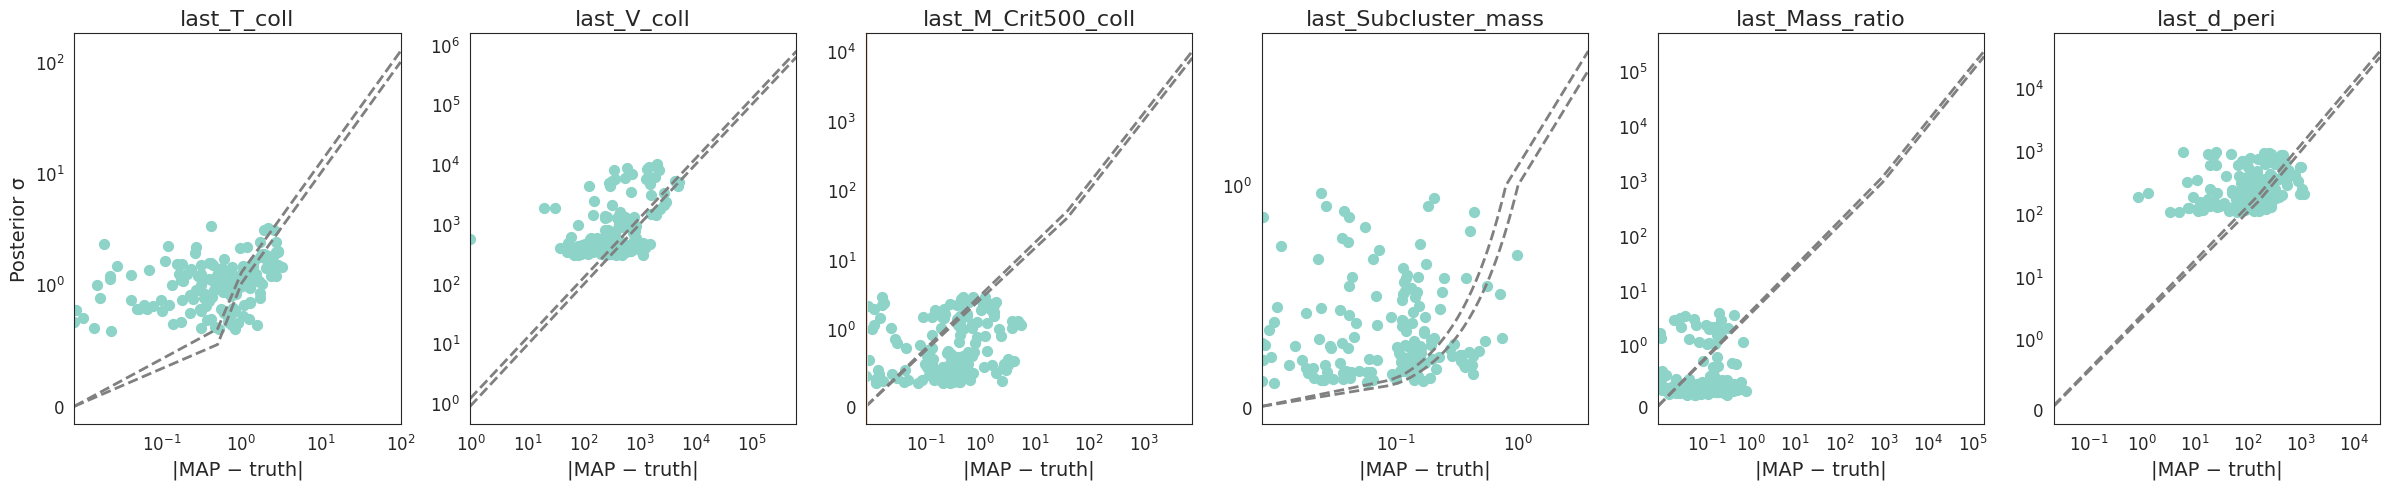

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])
        
        p5, p95 = np.percentile(std_d, [5, 80])
        mask = (std_d > p5) & (std_d < p95)
        # scatter
        ax.scatter(err_d[mask], std_d[mask], s=50, alpha=1.0)

        # idea gaussian lines
        lims = np.linspace(err_d.min(), err_d.max(), 200)
        ax.plot(lims, lims, '--', color='gray', linewidth=2)
        ax.plot(lims, lims * np.sqrt(np.pi / 2), '--', color='gray', linewidth=2)

        # symlog on both axes
        ax.set_xscale("symlog", linthresh=linthresh_x, linscale=1.0)
        ax.set_yscale("symlog", linthresh=linthresh_y, linscale=1.0)

        # vertical zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # lock axis limits to data ranges
        ax.set_xlim(err_d.min(), err_d.max())
        ax.set_ylim(p5, p95)

        # labels & title
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )


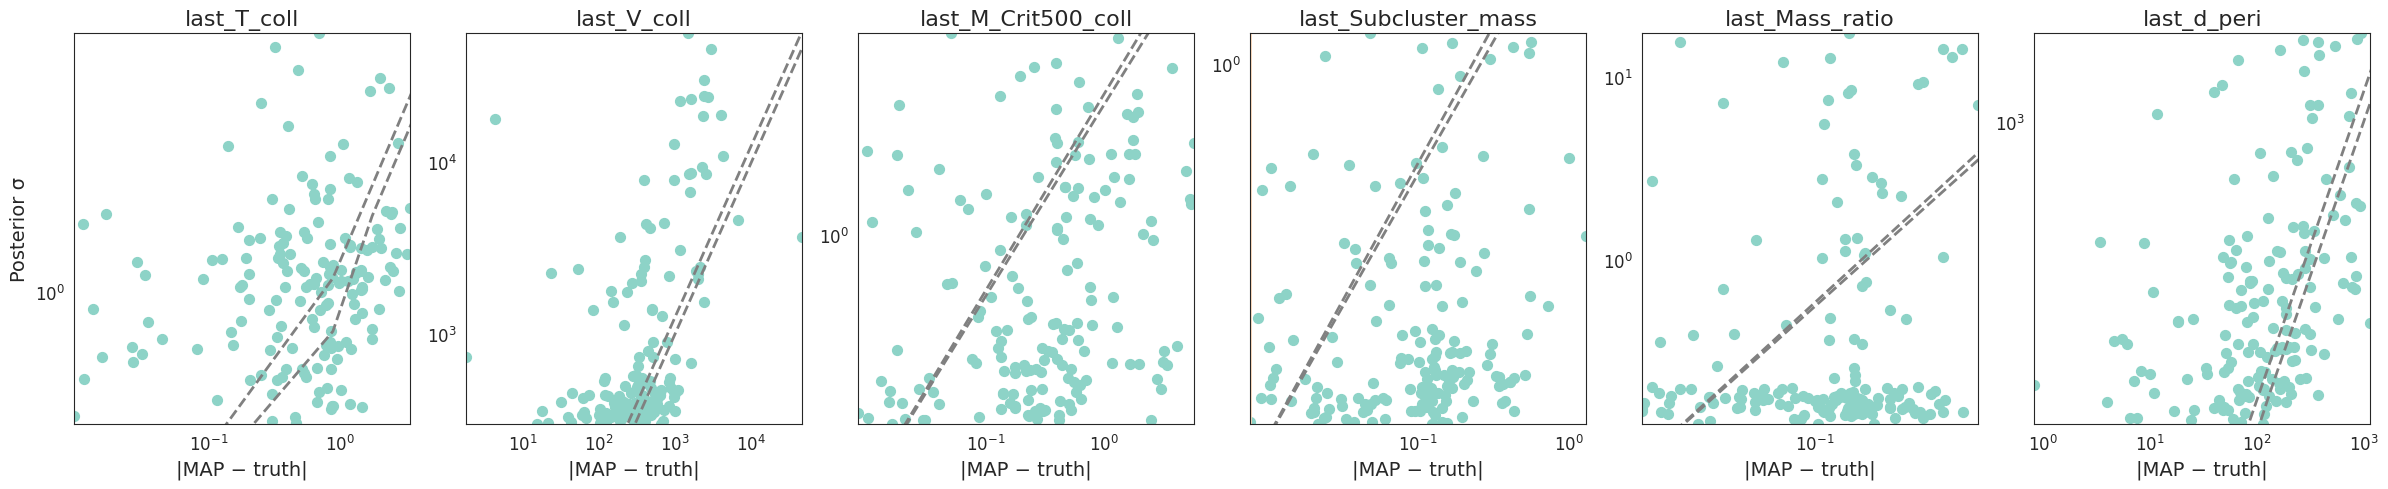

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])
        
        # compute your 5th/95th percentiles on σ
        p5, p95 = np.percentile(std_d, [5, 80])
        # mask both arrays
        mask = (std_d >= p5) & (std_d <= p95)
        
        # scatter only the in‐range points
        ax.scatter(err_d[mask], std_d[mask], s=50, alpha=1.0)

        # ideal gaussian reference lines
        lims = np.linspace(err_d.min(), err_d.max(), 200)
        ax.plot(lims, lims,      '--', color='gray', linewidth=2)
        ax.plot(lims, lims*np.sqrt(np.pi/2), '--', color='gray', linewidth=2)

        # symlog on both axes
        ax.set_xscale("symlog", linthresh=linthresh_x, linscale=1.0)
        ax.set_yscale("symlog", linthresh=linthresh_y, linscale=1.0)

        # vertical zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # now lock both limits to the masked data ranges
        ax.set_xlim(err_d[mask].min(),  err_d[mask].max())
        ax.set_ylim(std_d[mask].min(), std_d[mask].max())

        # labels & title
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.tick_params(labelsize=12)


    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )§


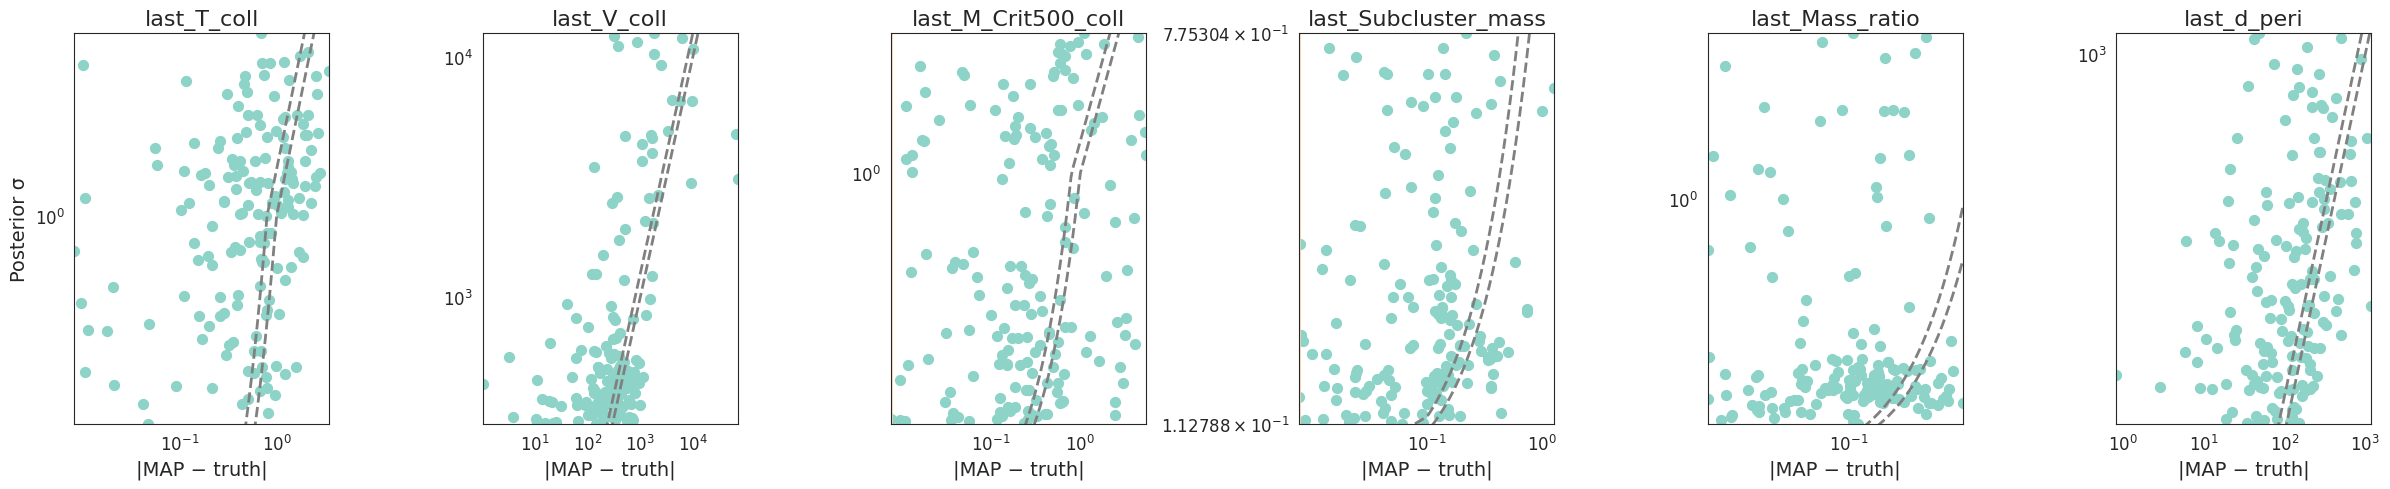

In [16]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from cluster_cinn import cINN

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    linthresh_x: float = 0.1,
    linthresh_y: float = 0.05,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])
        
        # compute your 5th/95th percentiles on σ
        p5, p95 = np.percentile(std_d, [5, 80])
        # mask both arrays
        mask = (std_d >= p5) & (std_d <= p95)
        
        # scatter only the in‐range points
        ax.scatter(err_d[mask], std_d[mask], s=50, alpha=1.0)

        # ideal gaussian reference lines
        lims = np.linspace(err_d[mask].min(), err_d[mask].max(), 200)
        ax.plot(lims, lims,      '--', color='gray', linewidth=2)
        ax.plot(lims, lims*np.sqrt(np.pi/2), '--', color='gray', linewidth=2)

        # symlog on both axes
        ax.set_xscale("symlog", linthresh=linthresh_x, linscale=1.0)
        ax.set_yscale("symlog", linthresh=linthresh_y, linscale=1.0)

        # vertical zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # now lock both limits to the masked data ranges
        ax.set_xlim(err_d[mask].min(),  err_d[mask].max())
        ax.set_ylim(std_d[mask].min(), std_d[mask].max())

        # labels & title
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.tick_params(labelsize=12)


    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=12,
        linthresh_x=0.1,
        linthresh_y=1,
        random_state=42
    )


In [2]:
import seaborn as sns
sns.set_style("white")

/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_53533/180872621.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be load

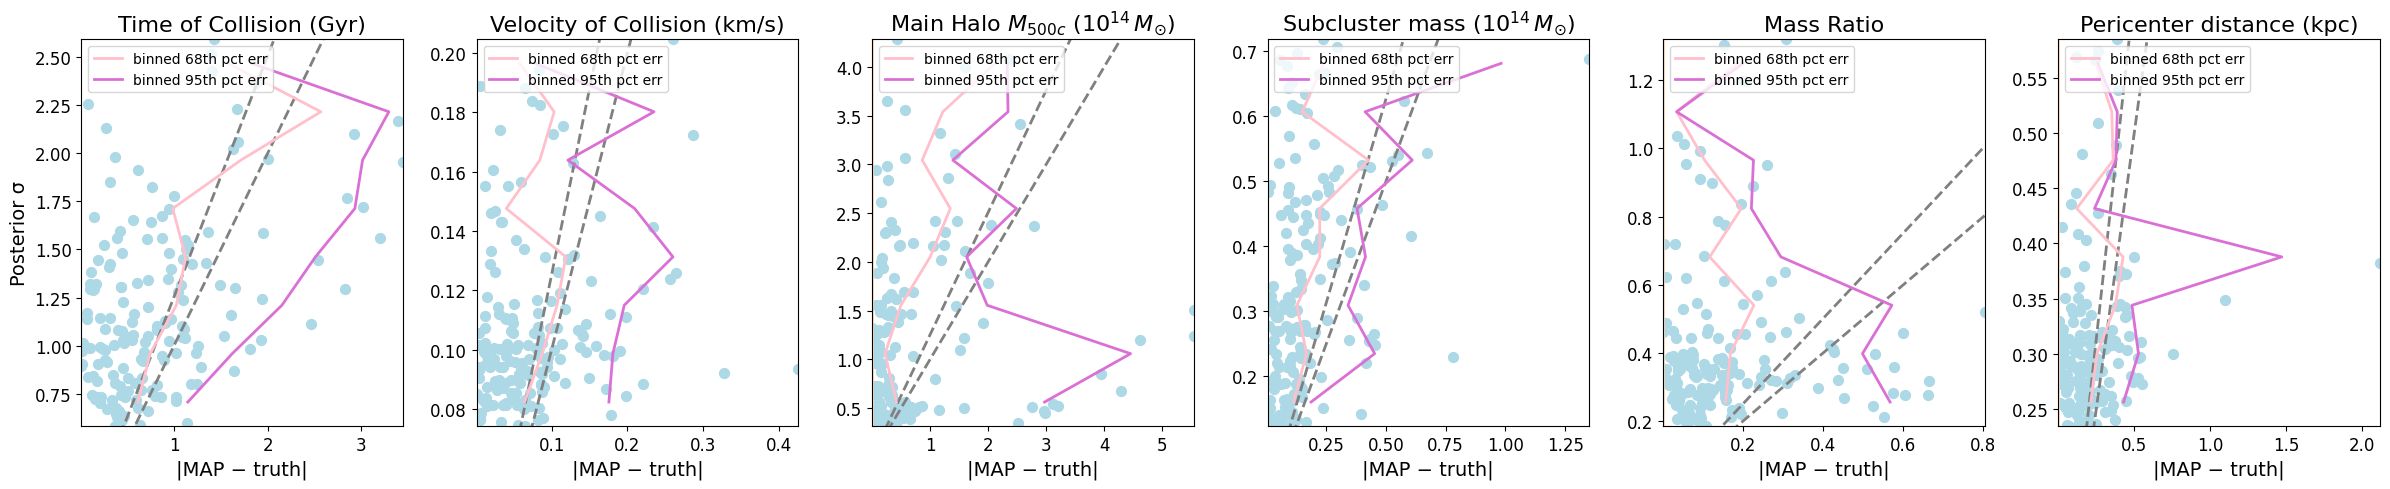

In [5]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

from model import cINN

TARGET_COLS = [
    'Time of Collision (Gyr)',
    'Velocity of Collision (km/s)',
    r'Main Halo $M_{500c}$ ($10^{14} \, M_{\odot}$)',
    r'Subcluster mass ($10^{14} \, M_{\odot}$)',
    'Mass Ratio',
    'Pericenter distance (kpc)',
]
def plot_error_vs_std_scatter(
    model_checkpoint: str,
    processed_dir: str = "processed_data",
    n_posterior_samples: int = 600,
    num_bins: int = 10,
    random_state: int = 42
):
    """
    For each target:
      • Draw n_posterior_samples from the cINN posterior.
      • Compute posterior std and MAP via KDE.
      • Compute abs error = |MAP – truth|.
      • Scatter |error| vs std (large opaque dots).
      • Apply symlog scaling on both axes, with separate linthresh values.
      • Lock axes to the data ranges.
      X‐axis = |MAP–truth|, Y‐axis = posterior σ.
    """
    # 1) load
    dfX    = pd.read_csv(os.path.join(processed_dir, "X.csv"))
    dfY    = pd.read_csv(os.path.join(processed_dir, "Y.csv"))
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))
    X_full, Y_full = dfX.values, dfY.values
    N, D_obs = X_full.shape
    _, D_tar = Y_full.shape
    assert D_tar == len(TARGET_COLS)

    # 2) test split
    idx = np.arange(N)
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test, Y_test = X_full[idx_test], Y_full[idx_test]
    truth_phys = tar_sc.inverse_transform(Y_test)

    # 3) load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = cINN(D_tar, D_obs, 128, 12, 2.0).to(device)
    ckpt   = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(ckpt)
    model.eval()

    # 4) sample posterior → std & MAP
    N_test   = X_test.shape[0]
    std_phys = np.zeros((N_test, D_tar))
    map_phys = np.zeros((N_test, D_tar))

    for i in range(N_test):
        x0 = torch.tensor(X_test[i:i+1], dtype=torch.float32, device=device)
        Z  = torch.randn(n_posterior_samples, D_tar, device=device)
        with torch.no_grad():
            inv = model.inverse(Z, x0.repeat(n_posterior_samples, 1))
        Ys = inv[0] if isinstance(inv, tuple) else inv
        samps = tar_sc.inverse_transform(Ys.cpu().numpy())

        std_phys[i] = samps.std(axis=0)
        for d in range(D_tar):
            arr = samps[:, d][:, None]
            kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(arr)
            grid = np.linspace(arr.min(), arr.max(), 200)[:, None]
            logd = kde.score_samples(grid)
            map_phys[i, d] = grid[np.argmax(logd), 0]

    # 5) plot scatter
    fig, axes = plt.subplots(1, D_tar, figsize=(4 * D_tar, 5), squeeze=False)
    for d, ax in enumerate(axes[0]):
        std_d = std_phys[:, d]
        err_d = np.abs(map_phys[:, d] - truth_phys[:, d])

        #make a mask to take the ones within the 5th and 95th percentiles
        p5, p95 = np.percentile(std_d, [5, 80])
        mask = (std_d >= p5) & (std_d <= p95)
        std_d = std_d[mask]
        err_d = err_d[mask]

        # scatter
        ax.scatter(err_d, std_d, s=50, alpha=1.0, color = 'lightblue')

        # ideal Gaussian ref lines
        lims = np.linspace(err_d.min(), err_d.max(), 200)
        ax.plot(lims, lims,                    '--', color='gray', linewidth=2)
        ax.plot(lims, lims * np.sqrt(np.pi/2), '--', color='gray', linewidth=2)

        # ---- new: binned percentiles of error in σ-bins ----
        # 1) define bins along σ
        bin_edges   = np.linspace(std_d.min(), std_d.max(), num_bins + 1)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # 2) compute per-bin 68th & 95th error
        pct68 = np.empty(num_bins)
        pct95 = np.empty(num_bins)
        for i in range(num_bins):
            sel = (std_d >= bin_edges[i]) & (std_d < bin_edges[i+1])
            if sel.any():
                pct68[i] = np.percentile(err_d[sel], 68)
                pct95[i] = np.percentile(err_d[sel], 95)
            else:
                pct68[i] = np.nan
                pct95[i] = np.nan

        # 3) plot them (X = error percentile, Y = σ bin center)
        ax.plot(pct68, bin_centers, '-', color='pink',  linewidth=2,
                label='binned 68th pct err')
        ax.plot(pct95, bin_centers, '-', color='orchid', linewidth=2,
                label='binned 95th pct err')
        # -------------------------------------------------------

        # zero‐error line
        ax.axvline(0, color='peachpuff', linewidth=2)

        # linear axes & lock limits to clipped data
        ax.set_xlim(err_d.min(),  err_d.max())
        ax.set_ylim(std_d.min(), std_d.max())

        # labels, title, legend
        ax.set_title(TARGET_COLS[d], fontsize=16)
        ax.set_xlabel("|MAP − truth|", fontsize=14)
        if d == 0:
            ax.set_ylabel("Posterior σ", fontsize=14)
        ax.legend(fontsize=10, loc='upper left')
        ax.tick_params(labelsize=12)

    plt.tight_layout()

    plt.savefig("3.uncertainities.png", bbox_inches='tight')
    #plt.savefig("3.uncertainities.pdf", bbox_inches='tight')
    plt.show()



if __name__ == "__main__":
    plot_error_vs_std_scatter(
        model_checkpoint="best_cluster_cinn.pt",
        processed_dir="processed_data",
        n_posterior_samples=600,
        num_bins=8,
        random_state=42
    )


# making it in two cells